### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [115]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

import cv2
from shapely.geometry import LineString
import time

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [116]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


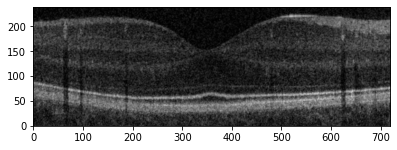

In [117]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [118]:
import time

start_time = time.time()
function_times = {}

def measure_time(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        function_time = te - ts
        
        if f.__name__ not in function_times:
            function_times[f.__name__] = [0, 0]  # [total_time, call_count]
        function_times[f.__name__][0] += function_time
        function_times[f.__name__][1] += 1
        
        return result
    
    return timed

def print_function_times():
    end_time = time.time()
    total_program_time = end_time - start_time
    
    print()
    print("### PROFILING ###")
    print("Total program time: {:.2f} sec".format(total_program_time))
    print("Function times:")
    for function_name, (total_time, call_count) in function_times.items():
        percentage = (total_time / total_program_time) * 100
        average_time = total_time / call_count
        print("- {}: {:.2f} sec ({:.2f}%), {} calls".format(
            function_name, total_time, percentage, call_count, average_time))
    print()

In [119]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def bezier_tangent(self, t):
        P0, P1, P2 = self.control_points()
        return 2 * (1 - t) * (P1 - P0) + 2 * t * (P2 - P1)
    
    @measure_time
    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        height, width = image.shape[:2]
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, width - 1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, height - 1)
        colours = [image[point[1],point[0]] for point in intermediates] #? had to swap point[1] and point[0] cause y and x were in the other order
        return(np.array(colours)/255)
    
    @measure_time
    def colour_along_width(self, image):
        # Calculate the bounding box of the worm
        min_x, min_y = np.min(self.control_points(), axis=0)
        max_x, max_y = np.max(self.control_points(), axis=0)

        # Calculate the four corners of the bounding box
        top_left = (min_x, min_y)
        top_right = (max_x, min_y)
        bottom_left = (min_x, max_y)
        bottom_right = (max_x, max_y)

        # Sample colors at the four corners
        image_height, image_width = image.shape[:2]
        corner_colors = []
        for corner in [top_left, top_right, bottom_left, bottom_right]:
            x, y = np.clip(corner, (0, 0), (image_width - 1, image_height - 1)).astype(int)
            corner_colors.append(image[y, x])

        # Average the corner colors
        average_color = np.mean(corner_colors, axis=0)

        return average_color / 255  # Normalize if needed

    
    @measure_time
    def img_color_across_t(self, t, image):
        # average image colour across all points in t 
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t))])


In [120]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms, alpha=1.0, colour=None):
        colourmap = mpl.colormaps["rainbow"]
        try:
            for worm in worms:
                patch = worm.patch()
                patch.set_alpha(alpha)
                if colour != None:
                    patch.set_edgecolor(colourmap(colour))
                self.ax.add_patch(patch)
        except TypeError:
            patch = worms.patch()
            patch.set_alpha(alpha)
            if colour != None:
                patch.set_edgecolor(colourmap(colour))
            self.ax.add_patch(patch)

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [121]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [122]:
# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

0.12745098039215685


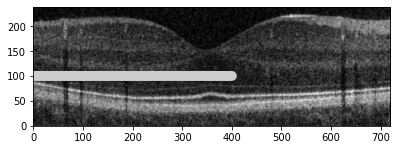

In [123]:


def paths_cross(path1, path2):
    """Determines if two Matplotlib paths cross."""
    line1 = LineString(path1.vertices)
    line2 = LineString(path2.vertices)
    
    # Check if the lines intersect and that the intersection is not just touching
    if line1.intersects(line2) and not line1.touches(line2):
        return True
    return False

worm1 = Camo_Worm(200, 100, 200, 0, 0, np.pi/4, 10, 0.8)
print(worm1.colour_along_width(image))


# Example usage:
worm2 = Camo_Worm(200, 110, 200, np.pi/2, 0, np.pi/4, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm1)
#drawing.add_worms(worm2)
drawing.show()


In [124]:
class Fitness:
    def __init__(self, image, swarms):
        self.image = image
        self.swarms = swarms
        self.times = {}
        
    @measure_time
    def get(self, worm):
        img_height, img_width = self.image.shape[:2]
        # colour factor
        @measure_time
        def colour():
            DIVISIONS = 8
            t = np.linspace(0,1,DIVISIONS)
            # subtract from 1 since higher fitness is better
            return (DIVISIONS-sum(np.abs(worm.colour - worm.img_color_across_t(t, self.image))), 5 / DIVISIONS)

        @measure_time
        # colour at width
        def w_colour():
            return (1 - np.mean(np.abs(worm.colour - worm.colour_along_width(self.image))),4)
            
        @measure_time
        # width factor
        def width():
            #deviation = abs(worm.width - 6)
            #fitness = np.exp(-(deviation ** 2) / (2 * 4 ** 2))
            if worm.width < 6:
                return (worm.width-6,0.05)
            if worm.width > 7:
                return(-worm.width+7,0.05)
            return (0,0)
            #return (fitness, 2)

        @measure_time
        # length factor
        def length():
            #deviation = abs(worm.r - img_width/8)
            #fitness = np.exp(-(deviation ** 2) / (2 * 4 ** 2))
            # provides benefit up to a certain value then no more benefit
            return (min(worm.r/(img_width/16),1),0.5)
            #return (fitness, 2)

        @measure_time
        def curvature():
            return (worm.dr/1, 0.3)

        @measure_time
        # discourage from going out of bounds
        def outside():
            min_x, min_y = np.min(worm.control_points(), axis=0)
            max_x, max_y = np.max(worm.control_points(), axis=0)
            if min_x < 0 or max_x >= img_width or min_y < 0 or max_y >= img_height:
                return (-1, 10)  # high cost for going outside
            else:
                return (0, 0) # doesn't affect worm if it's inside boundaries

        @measure_time
        # distance between swarms
        def g_distance():
            closest_worm = None
            min_distance = float('inf')  # Initialize with a large number
            SKIPRATE = 0.02
            # Iterate through each swarm and each worm within the swarm
            for s in random.sample(swarms, int(len(swarms)*SKIPRATE)):
                for other_worm in random.sample(s.population, int(len(s.population)*SKIPRATE)):
                    if other_worm == worm:
                        continue
                    # Calculate Euclidean distance
                    distance = ((worm.x - other_worm.x) ** 2 + (worm.y - other_worm.y) ** 2) ** 0.5
                    if distance < min_distance:
                        min_distance = distance
                        closest_worm = other_worm  # Update the closest worm

            # Apply upper limit to distance based on image dimensions and number of swarms
            distance_limit = min(min_distance, min(img_width, img_height) * 2 / np.ceil(len(swarms) ** 0.5))
            
            # Normalize the distance
            normalized_distance = distance_limit / (min(img_width, img_height) / np.ceil(len(swarms) ** 0.5))
            return (normalized_distance, 1.2, closest_worm)
    
        # detect if the worm is crossing another, penalise heavily
        @measure_time
        def g_cross_factor():
            SKIPRATE = 0.02
            count = 0
            others = random.sample([s.population[0] for s in swarms], int(len(swarms)*SKIPRATE))
            for other in others:
                if other == worm:
                    continue
                if worm.path().intersects_path(other.path()):
                    # if the worms are more than 90 degrees in different rotations
                    # but theta is modulo between 0 and 2 pi so make sure to check for that
                    diff = abs(worm.theta - other.theta)
                    if diff > np.pi:
                        diff = 2*np.pi - diff
                    if diff > np.pi/2:
                        count += 1
            return (-count/(SKIPRATE*len(swarms[0].population)), 3)

        # detect if the worm is roughly parallel with its closest friend
        @measure_time
        def g_parallelism(closest_worm):
            r1 = worm.theta
            r2 = closest_worm.theta
            angle_diff = np.abs(r1 - r2)
            angle_diff = min(angle_diff, 2*np.pi - angle_diff)  # This accounts for wrapping around the circle

            # Normalize the difference to a score from 0 to 1
            # Maximum difference that affects parallelism is pi (180 degrees)
            similarity_score = 1 - (angle_diff / np.pi)  # Normalize the difference by pi
            
            return (similarity_score,0.2)

        # each factor is a tuple of (fitness, multiplier)
        #g_distance = g_distance()
        #g_cross_factor = g_cross_factor()
        #g_parallelism = g_parallelism(g_distance[2])
        factors = [outside(), length(), width(), colour(), g_cross_factor()]
        return sum([x[0] * x[1] for x in factors])

In [125]:
import random, copy
"""
Each Swarm represents a single worm 
"""
class Swarm:
    def __init__ (self, image, population):
        self.image = image
        self.population = population
        self.fitness = None # must be updated after Fitness class is created
        
        # CONSTANTS #
        
        # number of individuals in the selection tournament
        # a higher tnm_k means it will select more of the best, and less of the worst
        # may converge faster without as much exploration
        self.tnm_k = 3
        
        # rate of mutation which should be between 0 and 1
        # a high rate may prevent convergence, a low rate will need more iterations to converge
        self.m_rate = 0.01 
        
    @measure_time
    def update(self):
        assert(self.fitness != None)
        fitnesses = [fitness.get(x) for x in self.population]
        new_population = []
        size = len(self.population)
        for i in range(size):
            # tournament selection
            selected_ix = max(random.sample(range(size), self.tnm_k), key=lambda ix: fitnesses[ix])
            parent = self.population[selected_ix]
            # mutating
            height, width = image.shape[:2]
            #c_x = min(max(parent.x + random.uniform(-self.m_rate*width/2,self.m_rate*width/2),0),width)
            #c_y = min(max(parent.y + random.uniform(-self.m_rate*height/2,self.m_rate*height/2),0),height)
            c_x = parent.x
            c_y = parent.y
            max_r = max(width,height)/2
            c_r = min(max(parent.r + random.uniform(-self.m_rate*max_r/2,self.m_rate*max_r/2),0),max_r)
            c_colour = min(max(parent.colour + random.uniform(-self.m_rate/2,self.m_rate/2),0),1)
            c_theta = (parent.theta + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi)) % (np.pi*2)
            c_dr = min(max(parent.dr + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),-c_r),c_r)
            c_dgamma = min(max(parent.dgamma + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi),-np.pi),np.pi)
            c_width = min(max(parent.width + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),1),2*c_r)
            # child
            child = Camo_Worm(c_x, c_y, c_r, c_theta, c_dr, c_dgamma, c_width, c_colour)
            new_population.append(child)
        self.population = new_population
    @measure_time
    def avg_worm(self):
        avg = copy.deepcopy(self.population[0])
        for field in ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width']:
            setattr(avg, field, np.mean([getattr(w, field) for w in self.population]))
        return avg
    

Iteration: 1
Time Remaining: 877 seconds
Fitness: [3.37, 3.91, 2.96, -3.54, 0.17, 1.2, 2.86, -4.88, -5.05, -5.31, 0.961, -5.67, 3.32, 3.84, 2.46, 4.02, 4.33, 3.16, 2.73, 2.53, 2.15, 2.9, 1.77, -1.93, 4.12, 2.57, 3.08, 2.84, -1.25, 1.18, 3.96, 3.93, 2.67, 3.87, -0.0353, 4.84, 1.26, 1.3, 4.78, 1.63, 4.67, -0.351, 4.2, 2.13, 3.01, 4.18, -7.16, 2.86, 2.62, 2.74, 3.96, 1.69, -5.09, 1.77, 2.8, -7.82, 2.86, 2.82, -0.214, 0.968, 4.64, 3.15, 3.75, -5.34, 4.06, -4.2, -6.73, 4.61, -3.28, 1.94, 4.73, 1.23, -5.0, 1.63, 3.98, -2.63, 2.5, 4.63, -3.9, -6.86, 3.5, 2.03, 3.15, -3.25, -1.64, 4.16, -9.33, 1.11, 4.37, -5.78, 0.996, 1.54, -4.69, 4.67, 2.45, 3.09, 4.59, 2.59, 2.73, 4.53, 3.49, 4.56, 1.31, -9.07, -1.87, 3.65, -6.13, -0.599, 4.28, -4.76, -5.46, 4.86, 4.45, -0.785, -2.62, -7.39, 3.93, 2.35, 3.67, 4.45, 3.78, -4.95, 3.61, 4.12, -7.56, 3.77, 4.75, 4.55, 2.66, -0.218, 2.66, -6.37, 0.684, 0.603, 1.05, -8.65, 2.52, -4.21, 4.28, -7.77, -7.57, -0.0837, 0.954, -6.21, 3.87, 4.42, 4.08, 4.43, 1.37, -1.41

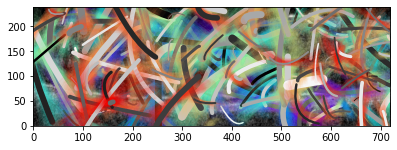


Iteration: 66
Time Remaining: 403 seconds
Fitness: [4.92, 4.77, 5.0, 4.74, 4.83, 4.99, 4.94, 3.89, 3.36, 4.69, 5.01, -4.87, 4.74, 4.83, 4.83, 3.7, 4.92, 5.06, 4.85, 4.89, 5.04, 4.97, 4.98, 4.91, 4.97, 4.93, 4.95, 4.98, 4.95, 5.05, 4.61, 4.96, 4.93, 4.87, 5.1, 5.05, 5.05, 4.77, 4.98, 4.92, 5.08, 5.0, 3.56, 4.9, 4.74, 4.86, 3.56, 5.02, 5.05, 4.38, 4.23, 4.16, 5.0, 4.75, 4.89, -0.748, 5.07, 3.71, 4.68, 4.84, 5.03, 3.89, 4.84, 0.482, 4.94, 4.48, 5.01, 4.88, 2.1, 5.02, 5.03, 4.98, 3.47, 5.09, 4.95, 4.48, 5.13, 4.95, 2.27, 3.6, 4.92, 4.18, 4.83, 4.6, 5.14, 5.0, -4.63, 5.13, 5.01, 4.55, 4.83, 4.9, 4.49, 5.08, 5.12, 4.93, 4.95, 5.1, 5.04, 5.1, 4.86, 4.96, 4.83, 4.88, 5.1, 4.6, 4.98, 4.51, 5.15, 4.54, 2.43, 4.99, 5.15, 3.65, 5.08, 4.79, 4.77, 5.09, 5.06, 4.87, 4.92, 1.41, 4.87, 5.06, 5.18, 5.05, 5.16, 3.06, 4.81, 4.82, 4.98, 4.74, 3.65, 5.08, 4.6, 4.9, 4.95, 0.323, 5.03, 0.944, 4.92, 4.31, 5.09, 3.33, 4.77, 5.1, 5.11, 5.01, 5.04, 4.46, 5.16, 5.07, 4.97, 5.1, 4.64, -4.76, 5.0, 5.06, 4.9, 4.26, 

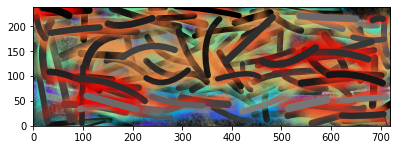


Iteration: 132
Time Remaining: 199 seconds
Fitness: [5.09, 5.12, 5.19, 5.2, 4.54, 5.0, 5.27, 5.33, 4.97, 5.2, 5.23, -4.7, 4.88, 5.17, 5.13, 4.78, 5.2, 5.1, 5.03, 5.09, 5.19, 5.1, 5.15, 5.03, 5.14, 4.91, 5.07, 5.17, 5.2, 5.25, 5.17, 5.12, 5.06, 5.11, 5.24, 5.25, 5.23, 5.1, 4.95, 5.21, 5.2, 5.1, 4.96, 5.2, 5.08, 4.97, 5.04, 5.18, 5.15, 4.5, 4.47, 4.21, 5.14, 4.95, 5.08, 1.85, 5.19, 3.54, 5.21, 5.02, 5.22, 4.05, 5.05, 2.85, 4.42, 3.38, 5.23, 4.88, 2.12, 5.24, 5.16, 4.93, 4.65, 5.18, 5.07, 5.25, 5.29, 5.16, -0.218, 5.35, 5.23, 4.95, 4.87, 5.34, 5.21, 5.11, -4.64, 5.24, 5.01, 5.22, 5.26, 4.81, 4.12, 5.0, 5.13, 5.26, 4.99, 5.19, 5.11, 5.09, 5.18, 5.18, 4.78, 5.34, 5.22, 5.09, 5.18, 4.45, 5.23, 4.83, 4.15, 5.18, 5.33, 5.19, 4.8, 4.93, 5.18, 5.14, 5.13, 5.1, 5.1, 1.14, 4.99, 5.08, 5.32, 5.2, 5.3, 4.17, 4.88, 5.13, 5.09, 4.01, 5.02, 5.1, 5.07, 5.13, 5.13, 2.28, 4.88, 3.94, 5.2, 4.29, 5.26, 4.53, 5.2, 5.26, 5.07, 5.1, 5.04, 4.66, 5.27, 5.05, 5.1, 5.2, 4.35, -4.56, 5.29, 5.17, 5.18, 5.24, 5.25, 

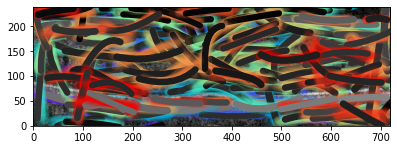


Iteration: 198
Time Remaining: 5 seconds
Fitness: [4.84, 5.33, 5.22, 5.22, 4.96, 5.05, 5.16, 5.39, 4.58, 5.28, 5.21, -4.66, 5.1, 5.19, 5.19, 5.01, 5.29, 5.34, 5.15, 5.1, 5.21, 5.25, 5.31, 5.17, 5.15, 4.88, 5.25, 5.31, 5.27, 5.28, 5.16, 4.97, 5.17, 5.22, 5.33, 5.29, 5.23, 5.06, 5.11, 5.35, 5.28, 5.22, 5.06, 5.18, 5.0, 4.91, 4.9, 5.15, 5.18, 3.76, 4.87, 4.69, 5.2, 5.1, 5.14, 1.37, 5.25, 4.23, 4.86, 5.3, 5.28, 4.9, 5.21, 5.11, 5.19, 4.94, 5.26, 4.99, 3.98, 5.24, 5.27, 5.16, 4.94, 5.15, 5.19, 5.35, 5.25, 5.19, 2.46, 4.94, 5.27, 5.09, 5.08, 5.24, 5.33, 5.22, -4.56, 5.26, 4.89, 5.24, 5.24, 5.26, 5.14, 5.19, 5.23, 5.29, 5.25, 5.16, 5.04, 5.18, 5.22, 5.22, 5.01, 5.38, 5.38, 5.08, 5.27, 4.91, 5.26, 4.68, 4.63, 5.25, 5.32, 5.21, 5.25, 5.34, 5.21, 5.24, 5.29, 5.21, 5.16, 3.74, 5.16, 5.3, 5.36, 5.25, 5.26, 3.54, 5.09, 5.25, 5.33, 5.04, 5.27, 5.14, 5.25, 5.23, 5.3, 3.09, 5.11, -1.63, 5.26, 5.07, 5.28, 4.0, 5.11, 5.31, 5.26, 5.22, 5.2, 5.13, 5.25, 5.23, 5.32, 5.24, 4.92, -4.52, 5.24, 5.3, 5.3, 5.33

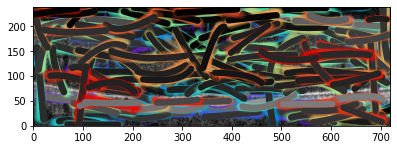

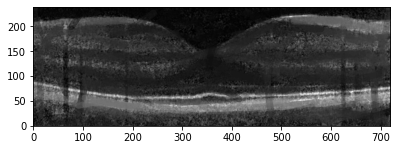

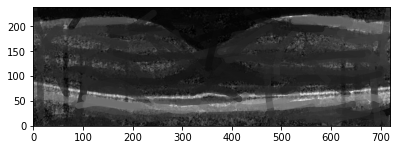

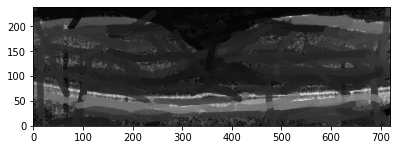

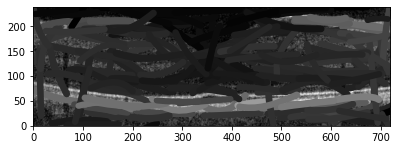

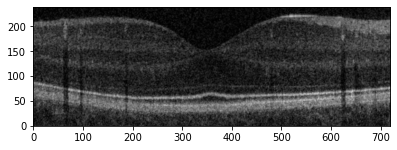

In [127]:
# for profiling
start_time = time.time()
function_times = {}
profiling = False # change to True to see function times
# constants
iterations = 200
swarm_size = 50
num_swarms = 200
swarms = []
for s in range(num_swarms):
    worm = random_worm(image.shape, (40, 30, 1))
    swarms.append(Swarm(image, [worm for _ in range(swarm_size)]))
fitness = Fitness(image, swarms)
for s in swarms:
    s.fitness = fitness
    s.tnm_k = 2
    #s.m_rate = 0.03

for it in range(iterations):
    fitnesses = []
    for swarm in swarms:
        # start the mutation rate high for a short time then keep it low for a long time (exponential)
        # allows for fast exploration at the start with fine tuning of the final solution at the end
        swarm.m_rate = 0.1 * np.exp(-3 * (it / iterations)) + 0.01 # -3 growth rate so it quickly decreases
        # same principle with tournament size, except that it starts low and increases over time
        # if tournament size = population, all children will come from the best parent (no diversity)
        #swarm.tnm_k = max(int(len(swarm.population)/2 / (1+np.exp(-5 * (it/iterations-0.8)))+1), 2) 
        swarm.update()
    if (it+1) % (iterations//3) == 0 or int(it) == 0:
        all_fitnesses = [sum(x) / len(x) for x in [[fitness.get(w) for w in p.population] for p in swarms]]
        print("Iteration:",it+1)
        print("Time Remaining:",int((time.time() - start_time) / (it+1) * (iterations - (it+1))),"seconds")
        print("Fitness:",[float(f"{x:.3}") for x in all_fitnesses])
        print(f"Mutation Rate: {swarms[0].m_rate:.3}")
        print(f"Tournament Size: {swarms[0].tnm_k}")
        if profiling:
            print_function_times()
        drawing = Drawing(image)
        for ix in range(len(swarms)):
            drawing.add_worms(swarms[ix].population, alpha=0.05, colour=(ix/len(swarms)))
            drawing.add_worms(swarms[ix].avg_worm())
        drawing.show()
        print()
        
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm(), alpha=0.4)
drawing.show()
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm(), alpha=0.6)
drawing.show()
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm(), alpha=0.8)
drawing.show()
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm(), alpha=1)
drawing.show()
plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')
    